In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras import layers, losses
import keras_tuner
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("Datensatz.csv")

C:\Users\Florian\AppData\Local\Temp\ipykernel_2032\668810773.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Datensatz.csv")


In [3]:
df.drop(columns=["Unnamed: 0", "tier", "rank"], inplace=True)

In [4]:
df.winningTeam

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
165183    1.0
165184    1.0
165185    1.0
165186    1.0
165187    1.0
Name: winningTeam, Length: 165188, dtype: float64

In [5]:
Y = df["winningTeam"]
X = df[['minute',
       'player1_xp', 'player1_totalGold', 'player1_totalDamageDoneToChampions',
       'player1_totalDamageTaken', 'player1_level', 'player1_currentGold',
       'player1_minionsKilled', 'player1_jungleMinionsKilled', 'player2_xp',
       'player2_totalGold', 'player2_totalDamageDoneToChampions',
       'player2_totalDamageTaken', 'player2_level', 'player2_currentGold',
       'player2_minionsKilled', 'player2_jungleMinionsKilled', 'player3_xp',
       'player3_totalGold', 'player3_totalDamageDoneToChampions',
       'player3_totalDamageTaken', 'player3_level', 'player3_currentGold',
       'player3_minionsKilled', 'player3_jungleMinionsKilled', 'player4_xp',
       'player4_totalGold', 'player4_totalDamageDoneToChampions',
       'player4_totalDamageTaken', 'player4_level', 'player4_currentGold',
       'player4_minionsKilled', 'player4_jungleMinionsKilled', 'player5_xp',
       'player5_totalGold', 'player5_totalDamageDoneToChampions',
       'player5_totalDamageTaken', 'player5_level', 'player5_currentGold',
       'player5_minionsKilled', 'player5_jungleMinionsKilled', 'player6_xp',
       'player6_totalGold', 'player6_totalDamageDoneToChampions',
       'player6_totalDamageTaken', 'player6_level', 'player6_currentGold',
       'player6_minionsKilled', 'player6_jungleMinionsKilled', 'player7_xp',
       'player7_totalGold', 'player7_totalDamageDoneToChampions',
       'player7_totalDamageTaken', 'player7_level', 'player7_currentGold',
       'player7_minionsKilled', 'player7_jungleMinionsKilled', 'player8_xp',
       'player8_totalGold', 'player8_totalDamageDoneToChampions',
       'player8_totalDamageTaken', 'player8_level', 'player8_currentGold',
       'player8_minionsKilled', 'player8_jungleMinionsKilled', 'player9_xp',
       'player9_totalGold', 'player9_totalDamageDoneToChampions',
       'player9_totalDamageTaken', 'player9_level', 'player9_currentGold',
       'player9_minionsKilled', 'player9_jungleMinionsKilled', 'player10_xp',
       'player10_totalGold', 'player10_totalDamageDoneToChampions',
       'player10_totalDamageTaken', 'player10_level', 'player10_currentGold',
       'player10_minionsKilled', 'player10_jungleMinionsKilled',
       'skill_level']]

In [6]:
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size= 0.3, random_state=42, shuffle=True) 

Das Testdatenset wird aufgeteilt, um zu sehen wie die Vorhersage je nach Spieldauer ist.

In [7]:
x_train_not_normalized = x_train.copy()   #saving_for_plot
x_test_not_normalized = x_test.copy()      #saving_for_plot

for feature in x_test.columns:
    max_value = x_test[feature].max()
    min_value = x_test[feature].min()
    x_test[feature] = (x_test[feature] - min_value) / (max_value - min_value)
    
for feature in x_train.columns:
    max_value = x_train[feature].max()
    min_value = x_train[feature].min()
    x_train[feature] = (x_train[feature] - min_value) / (max_value - min_value)


#### Benutzen von Hyperparametersearch

In [17]:
def build_model(hp):  
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(
        hp.Choice('units1', [256, 128, 64, 32]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units2', [128, 64, 32, 16]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units3', [64, 32, 16, 8]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units4', [32, 16, 8, 4]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units5', [16, 8, 4, 2]),
        activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics = ['accuracy'])
    return model

In [18]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [13]:
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=128, verbose=3)
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps)

Trial 100 Complete [00h 01m 49s]
val_loss: 0.5806021094322205

Best val_loss So Far: 0.5377615094184875
Total elapsed time: 04h 35m 04s
INFO:tensorflow:Oracle triggered exit


In [13]:
best_hps=tuner.get_best_hyperparameters()[0]
print(f"""
units1:{best_hps.get('units1')}
units2:{best_hps.get('units2')}
units3:{best_hps.get('units3')}
units4:{best_hps.get('units4')}
units5:{best_hps.get('units5')}
learning_rate:{best_hps.get('learning_rate')}.
""")


units1:64
units2:128
units3:64
units4:32
units5:16
learning_rate:0.001.



In [19]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=200,
                    validation_data=(x_test, y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/200


C:\Users\Florian\PycharmProjects\pythonProject\Seminararbeit_LOL\venv\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


891/904 [============================>.] - ETA: 0s - loss: 0.5577 - accuracy: 0.6912

C:\Users\Florian\PycharmProjects\pythonProject\Seminararbeit_LOL\venv\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


904/904 [==============================] - 4s 3ms/step - loss: 0.5573 - accuracy: 0.6915 - val_loss: 0.5301 - val_accuracy: 0.7119
Epoch 2/200
904/904 [==============================] - 3s 3ms/step - loss: 0.5320 - accuracy: 0.7105 - val_loss: 0.5250 - val_accuracy: 0.7135
Epoch 3/200
904/904 [==============================] - 2s 3ms/step - loss: 0.5225 - accuracy: 0.7181 - val_loss: 0.5150 - val_accuracy: 0.7245
Epoch 4/200
904/904 [==============================] - 2s 2ms/step - loss: 0.5149 - accuracy: 0.7216 - val_loss: 0.5235 - val_accuracy: 0.7134
Epoch 5/200
904/904 [==============================] - 2s 2ms/step - loss: 0.5100 - accuracy: 0.7254 - val_loss: 0.5161 - val_accuracy: 0.7185
Epoch 6/200
904/904 [==============================] - 2s 3ms/step - loss: 0.5018 - accuracy: 0.7290 - val_loss: 0.5044 - val_accuracy: 0.7276
Epoch 7/200
904/904 [==============================] - 2s 3ms/step - loss: 0.4957 - accuracy: 0.7327 - val_loss: 0.5085 - val_accuracy: 0.7273
Epoch 8/200

904/904 [==============================] - 2s 2ms/step - loss: 0.2783 - accuracy: 0.8486 - val_loss: 0.3652 - val_accuracy: 0.8154
Epoch 59/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2765 - accuracy: 0.8490 - val_loss: 0.3886 - val_accuracy: 0.8094
Epoch 60/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2737 - accuracy: 0.8507 - val_loss: 0.3966 - val_accuracy: 0.8097
Epoch 61/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2748 - accuracy: 0.8510 - val_loss: 0.3575 - val_accuracy: 0.8205
Epoch 62/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2716 - accuracy: 0.8516 - val_loss: 0.3538 - val_accuracy: 0.8232
Epoch 63/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2677 - accuracy: 0.8542 - val_loss: 0.3571 - val_accuracy: 0.8174
Epoch 64/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2701 - accuracy: 0.8531 - val_loss: 0.3653 - val_accuracy: 0.8148
Epoch

Epoch 115/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2139 - accuracy: 0.8822 - val_loss: 0.3395 - val_accuracy: 0.8396
Epoch 116/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2130 - accuracy: 0.8832 - val_loss: 0.3080 - val_accuracy: 0.8472
Epoch 117/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2135 - accuracy: 0.8822 - val_loss: 0.3589 - val_accuracy: 0.8341
Epoch 118/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2109 - accuracy: 0.8826 - val_loss: 0.3367 - val_accuracy: 0.8396
Epoch 119/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2116 - accuracy: 0.8845 - val_loss: 0.3807 - val_accuracy: 0.8319
Epoch 120/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2121 - accuracy: 0.8830 - val_loss: 0.3424 - val_accuracy: 0.8391
Epoch 121/200
904/904 [==============================] - 2s 2ms/step - loss: 0.2099 - accuracy: 0.8838 - val_loss: 0.3441 - val_ac

In [20]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data=(x_test, y_test))


Epoch 1/189


C:\Users\Florian\PycharmProjects\pythonProject\Seminararbeit_LOL\venv\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3584/3614 [============================>.] - ETA: 0s - loss: 0.5482 - accuracy: 0.6972

C:\Users\Florian\PycharmProjects\pythonProject\Seminararbeit_LOL\venv\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3614/3614 [==============================] - 8s 2ms/step - loss: 0.5480 - accuracy: 0.6974 - val_loss: 0.5226 - val_accuracy: 0.7176
Epoch 2/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.5269 - accuracy: 0.7134 - val_loss: 0.5287 - val_accuracy: 0.7058
Epoch 3/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.5200 - accuracy: 0.7171 - val_loss: 0.5271 - val_accuracy: 0.7176
Epoch 4/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.5139 - accuracy: 0.7225 - val_loss: 0.5229 - val_accuracy: 0.7106
Epoch 5/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.5070 - accuracy: 0.7261 - val_loss: 0.5098 - val_accuracy: 0.7252
Epoch 6/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.5021 - accuracy: 0.7291 - val_loss: 0.5758 - val_accuracy: 0.6911
Epoch 7/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.4973 - accuracy: 0.7307 - val_loss: 0.5044 - val_accuracy: 0.72

3614/3614 [==============================] - 7s 2ms/step - loss: 0.2212 - accuracy: 0.8787 - val_loss: 0.3613 - val_accuracy: 0.8316
Epoch 114/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.2213 - accuracy: 0.8802 - val_loss: 0.3269 - val_accuracy: 0.8396
Epoch 115/189
3614/3614 [==============================] - 6s 2ms/step - loss: 0.2214 - accuracy: 0.8779 - val_loss: 0.3492 - val_accuracy: 0.8311
Epoch 116/189
3614/3614 [==============================] - 6s 2ms/step - loss: 0.2185 - accuracy: 0.8794 - val_loss: 0.3911 - val_accuracy: 0.8261
Epoch 117/189
3614/3614 [==============================] - 6s 2ms/step - loss: 0.2201 - accuracy: 0.8792 - val_loss: 0.3803 - val_accuracy: 0.8254
Epoch 118/189
3614/3614 [==============================] - 6s 2ms/step - loss: 0.2201 - accuracy: 0.8796 - val_loss: 0.4759 - val_accuracy: 0.8120
Epoch 119/189
3614/3614 [==============================] - 6s 2ms/step - loss: 0.2183 - accuracy: 0.8812 - val_loss: 0.3516 - val_ac

Epoch 169/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1915 - accuracy: 0.8931 - val_loss: 0.3354 - val_accuracy: 0.8477
Epoch 170/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1928 - accuracy: 0.8925 - val_loss: 0.3841 - val_accuracy: 0.8366
Epoch 171/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1905 - accuracy: 0.8933 - val_loss: 0.4281 - val_accuracy: 0.8345
Epoch 172/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1911 - accuracy: 0.8939 - val_loss: 0.3896 - val_accuracy: 0.8379
Epoch 173/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1896 - accuracy: 0.8956 - val_loss: 0.3466 - val_accuracy: 0.8442
Epoch 174/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1903 - accuracy: 0.8941 - val_loss: 0.3628 - val_accuracy: 0.8413
Epoch 175/189
3614/3614 [==============================] - 7s 2ms/step - loss: 0.1913 - accuracy: 0.8944 - val_loss: 0

In [28]:
#teile das testset in entsprechende Datenintervalle

x_test_0_4 = x_test_not_normalized.loc[x_test_not_normalized["minute"] < 5]
x_test_5_9 = x_test_not_normalized.loc[(x_test_not_normalized["minute"] >= 5) & (x_test_not_normalized["minute"] < 10)]
x_test_10_14 = x_test_not_normalized.loc[(x_test_not_normalized["minute"] >= 10) & (x_test_not_normalized["minute"] < 15)]
x_test_15_19 = x_test_not_normalized.loc[(x_test_not_normalized["minute"] >= 15) & (x_test_not_normalized["minute"] < 20)]
x_test_20_24 = x_test_not_normalized.loc[(x_test_not_normalized["minute"] >= 20) & (x_test_not_normalized["minute"] < 25)]
x_test_25_29 = x_test_not_normalized.loc[(x_test_not_normalized["minute"] >= 25) & (x_test_not_normalized["minute"] < 30)]
x_test_30_34 = x_test_not_normalized.loc[x_test_not_normalized["minute"] >= 30]

x_test_0_4 = x_test.loc[x_test_0_4.index]
x_test_5_9 = x_test.loc[x_test_5_9.index]
x_test_10_14 = x_test.loc[x_test_10_14.index]
x_test_15_19 = x_test.loc[x_test_15_19.index]
x_test_20_24 = x_test.loc[x_test_20_24.index]
x_test_25_29 = x_test.loc[x_test_25_29.index]
x_test_30_34 = x_test.loc[x_test_30_34.index]

#erzeugen eines dataframes mit den Features Minute und winningTeam 
y_test_with_minutes = df.iloc[y_test.index][["minute", "winningTeam"]]

#teile das Zielfeature des testsets in entsprechende Datenintervalle
y_test_0_4 = y_test_with_minutes.loc[y_test_with_minutes["minute"] < 5]["winningTeam"]
y_test_5_9 = y_test_with_minutes.loc[(y_test_with_minutes["minute"] >= 5) & (y_test_with_minutes["minute"] < 10)]["winningTeam"]
y_test_10_14 = y_test_with_minutes.loc[(y_test_with_minutes["minute"] >= 10) & (y_test_with_minutes["minute"] < 15)]["winningTeam"]
y_test_15_19 = y_test_with_minutes.loc[(y_test_with_minutes["minute"] >= 15) & (y_test_with_minutes["minute"] < 20)]["winningTeam"]
y_test_20_24 = y_test_with_minutes.loc[(y_test_with_minutes["minute"] >= 20) & (y_test_with_minutes["minute"] < 25)]["winningTeam"]
y_test_25_29 = y_test_with_minutes.loc[(y_test_with_minutes["minute"] >= 25) & (y_test_with_minutes["minute"] < 30)]["winningTeam"]
y_test_30_34 = y_test_with_minutes.loc[y_test_with_minutes["minute"] >= 30]["winningTeam"]




In [33]:
#create array with results
results = np.empty(7)

y_pred_4 = hypermodel.predict(x_test_0_4)
results[0] = accuracy_score(y_test_0_4, y_pred_4.round())
y_pred_9 = hypermodel.predict(x_test_5_9)
results[1] = accuracy_score(y_test_5_9, y_pred_9.round())                            
y_pred_14 = hypermodel.predict(x_test_10_14)
results[2] = accuracy_score(y_test_10_14, y_pred_14.round())
y_pred_19 = hypermodel.predict(x_test_15_19)
results[3] = accuracy_score(y_test_15_19, y_pred_19.round())
y_pred_24 = hypermodel.predict(x_test_20_24)
results[4] = accuracy_score(y_test_20_24, y_pred_24.round())
y_pred_29 = hypermodel.predict(x_test_25_29)
results[5] = accuracy_score(y_test_25_29, y_pred_29.round())
y_pred_30_and_more = hypermodel.predict(x_test_30_34)
results[6] = accuracy_score(y_test_30_34, y_pred_30_and_more.round())

#create df with results
df_lr_results = pd.DataFrame(results)
df_lr_results["x_ticks"] = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30+']


163/163 [==============================] - 0s 889us/step


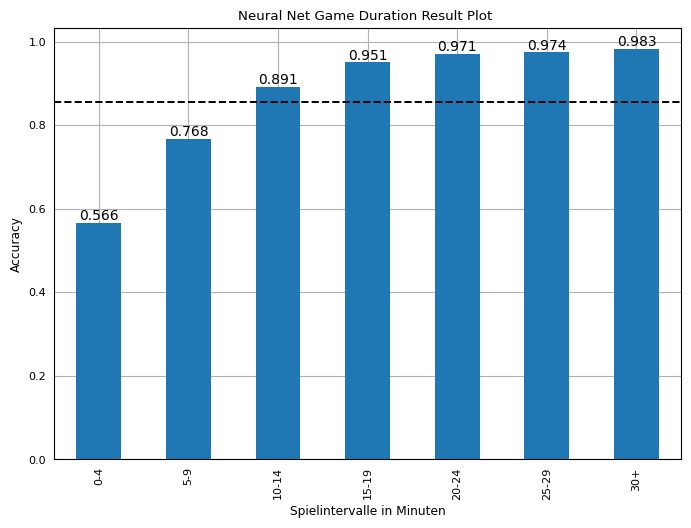

In [48]:
overall_result = round(history.history["val_accuracy"][-1],3)

plt.style.use('_mpl-gallery')
plt.style.use('seaborn-v0_8-paper')
ax = df_lr_results.plot(kind='bar', title='Neural Net Game Duration Result Plot ', xlabel="Spielintervalle in Minuten", ylabel="Accuracy", legend=False)
ax.set_xticklabels(df_lr_results.x_ticks)
#ax.set_yticklabels(np.arange(0, 1, step=0.1))
ax.axhline(overall_result, color="black", linestyle="--")
ax.bar_label(ax.containers[0])

for text in ax.texts:
    t = float(text.get_text())                 
    text.set_text(round(t, 3))


In [40]:
round(history.history["val_accuracy"][-1],3)


0.856

### Skill Prediction

In [4]:
Y = df["skill_level"]
X = df[['minute',
       'player1_xp', 'player1_totalGold', 'player1_totalDamageDoneToChampions',
       'player1_totalDamageTaken', 'player1_level', 'player1_currentGold',
       'player1_minionsKilled', 'player1_jungleMinionsKilled', 'player2_xp',
       'player2_totalGold', 'player2_totalDamageDoneToChampions',
       'player2_totalDamageTaken', 'player2_level', 'player2_currentGold',
       'player2_minionsKilled', 'player2_jungleMinionsKilled', 'player3_xp',
       'player3_totalGold', 'player3_totalDamageDoneToChampions',
       'player3_totalDamageTaken', 'player3_level', 'player3_currentGold',
       'player3_minionsKilled', 'player3_jungleMinionsKilled', 'player4_xp',
       'player4_totalGold', 'player4_totalDamageDoneToChampions',
       'player4_totalDamageTaken', 'player4_level', 'player4_currentGold',
       'player4_minionsKilled', 'player4_jungleMinionsKilled', 'player5_xp',
       'player5_totalGold', 'player5_totalDamageDoneToChampions',
       'player5_totalDamageTaken', 'player5_level', 'player5_currentGold',
       'player5_minionsKilled', 'player5_jungleMinionsKilled', 'player6_xp',
       'player6_totalGold', 'player6_totalDamageDoneToChampions',
       'player6_totalDamageTaken', 'player6_level', 'player6_currentGold',
       'player6_minionsKilled', 'player6_jungleMinionsKilled', 'player7_xp',
       'player7_totalGold', 'player7_totalDamageDoneToChampions',
       'player7_totalDamageTaken', 'player7_level', 'player7_currentGold',
       'player7_minionsKilled', 'player7_jungleMinionsKilled', 'player8_xp',
       'player8_totalGold', 'player8_totalDamageDoneToChampions',
       'player8_totalDamageTaken', 'player8_level', 'player8_currentGold',
       'player8_minionsKilled', 'player8_jungleMinionsKilled', 'player9_xp',
       'player9_totalGold', 'player9_totalDamageDoneToChampions',
       'player9_totalDamageTaken', 'player9_level', 'player9_currentGold',
       'player9_minionsKilled', 'player9_jungleMinionsKilled', 'player10_xp',
       'player10_totalGold', 'player10_totalDamageDoneToChampions',
       'player10_totalDamageTaken', 'player10_level', 'player10_currentGold',
       'player10_minionsKilled', 'player10_jungleMinionsKilled',
       'winningTeam']]

In [5]:
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size= 0.3, random_state=42, shuffle=True)

In [6]:
def build_model_skill_pred(hp): 
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(
        hp.Choice('units1', [256, 128, 64, 32]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units2', [128, 64, 32, 16]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units3', [64, 32, 16, 8]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units4', [32, 16, 8, 4]),
        activation='relu'))
    model.add(layers.Dense(
        hp.Choice('units5', [16, 8, 4, 2]),
        activation='relu'))
    model.add(layers.Dense(1, activation=tf.keras.layers.Activation('linear')))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = tf.keras.losses.MeanSquaredError(),
        metrics = [tf.keras.metrics.RootMeanSquaredError()])
    return model

In [7]:
tuner_skill_pred = keras_tuner.RandomSearch(
    build_model_skill_pred,
    objective='val_loss',
    max_trials=200)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [64]:
tuner_skill_pred.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=128, verbose=3)
best_model = tuner_skill_pred.get_best_models()[0]
best_hps=tuner_skill_pred.get_best_hyperparameters()[0]
print(best_hps)

Trial 200 Complete [00h 08m 06s]
val_loss: 75.19782257080078

Best val_loss So Far: 0.5377615094184875
Total elapsed time: 04h 58m 40s
INFO:tensorflow:Oracle triggered exit


In [9]:
best_hps=tuner_skill_pred.get_best_hyperparameters()[0]
print(f"""
units1:{best_hps.get('units1')}
units2:{best_hps.get('units2')}
units3:{best_hps.get('units3')}
units4:{best_hps.get('units4')}
units5:{best_hps.get('units5')}
learning_rate:{best_hps.get('learning_rate')}.
""")


units1:64
units2:128
units3:64
units4:32
units5:16
learning_rate:0.001.



In [31]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_skill_pred.hypermodel.build(best_hps)
history = model.fit(x_train, y_train,
            batch_size=128,
            epochs=50,
            validation_data=(x_test, y_test))

Epoch 1/50
904/904 [==============================] - 4s 3ms/step - loss: 11805.9697 - root_mean_squared_error: 108.6553 - val_loss: 504.8093 - val_root_mean_squared_error: 22.4680
Epoch 2/50
904/904 [==============================] - 3s 3ms/step - loss: 263.4196 - root_mean_squared_error: 16.2302 - val_loss: 279.7693 - val_root_mean_squared_error: 16.7263
Epoch 3/50
904/904 [==============================] - 3s 3ms/step - loss: 168.5294 - root_mean_squared_error: 12.9819 - val_loss: 140.3675 - val_root_mean_squared_error: 11.8477
Epoch 4/50
904/904 [==============================] - 3s 3ms/step - loss: 149.3291 - root_mean_squared_error: 12.2200 - val_loss: 363.8156 - val_root_mean_squared_error: 19.0740
Epoch 5/50
904/904 [==============================] - 3s 3ms/step - loss: 139.4959 - root_mean_squared_error: 11.8108 - val_loss: 86.0484 - val_root_mean_squared_error: 9.2762
Epoch 6/50
904/904 [==============================] - 3s 3ms/step - loss: 124.8455 - root_mean_squared_error:

Epoch 48/50
904/904 [==============================] - 3s 3ms/step - loss: 30.1707 - root_mean_squared_error: 5.4928 - val_loss: 31.5787 - val_root_mean_squared_error: 5.6195
Epoch 49/50
904/904 [==============================] - 3s 3ms/step - loss: 29.3303 - root_mean_squared_error: 5.4157 - val_loss: 30.2138 - val_root_mean_squared_error: 5.4967
Epoch 50/50
904/904 [==============================] - 3s 3ms/step - loss: 29.3787 - root_mean_squared_error: 5.4202 - val_loss: 31.0635 - val_root_mean_squared_error: 5.5735


In [32]:
val_rmse_per_epoch = history.history['val_root_mean_squared_error']
best_epoch = val_rmse_per_epoch.index(min(val_rmse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 49


In [33]:
hypermodel_skill_pred = model

In [34]:
y_pred = hypermodel_skill_pred.predict(x_test)
y_pred = y_pred.reshape(-1,)
print('Model accuracy score with Neural Net : {0:0.4f}'. format(mean_squared_error(y_test, y_pred, squared=False)))

1549/1549 [==============================] - 2s 930us/step
Model accuracy score with Neural Net : 5.5735


In [35]:
tracking_error = round(y_pred-y_test)

Text(0, 0.5, 'occurences')

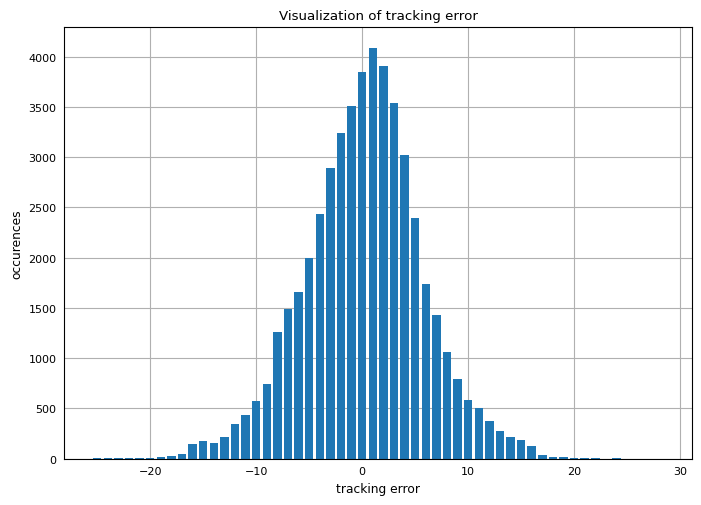

In [36]:
ax = plt.bar(tracking_error.value_counts().index, tracking_error.value_counts())
plt.title("Visualization of tracking error")
plt.xlabel("tracking error")
plt.ylabel("occurences")

In [37]:
df_combined = [tracking_error, y_test]
df_tracking_error = pd.concat( df_combined,axis=1,ignore_index=True)
df_tracking_error.columns = ["tracking_error", "y_test"]

In [38]:
tracking_error_iron = df_tracking_error.loc[df_tracking_error["y_test"]<=3, "tracking_error"]
tracking_error_bronze = df_tracking_error.loc[((df_tracking_error["y_test"]<=7) & (df_tracking_error["y_test"] > 3)), "tracking_error"]
tracking_error_silver = df_tracking_error.loc[((df_tracking_error["y_test"]<=11) & (df_tracking_error["y_test"] > 7)), "tracking_error"]
tracking_error_gold = df_tracking_error.loc[((df_tracking_error["y_test"]<=15) & (df_tracking_error["y_test"] > 11)), "tracking_error"]
tracking_error_platin = df_tracking_error.loc[((df_tracking_error["y_test"]<=19) & (df_tracking_error["y_test"] > 15)), "tracking_error"]
tracking_error_diamond = df_tracking_error.loc[((df_tracking_error["y_test"]<=23) & (df_tracking_error["y_test"] > 19)), "tracking_error"]
tracking_error_master = df_tracking_error.loc[df_tracking_error["y_test"]==24, "tracking_error"]
tracking_error_grandmaster = df_tracking_error.loc[df_tracking_error["y_test"]==28, "tracking_error"]
tracking_error_challenger = df_tracking_error.loc[df_tracking_error["y_test"]==32, "tracking_error"]

In [39]:
plt.style.use('_mpl-gallery')
plt.style.use('seaborn-v0_8-paper')
plt.figure(figsize=(10,10))
list_tracking_error = [tracking_error_iron.mean(), tracking_error_bronze.mean(), tracking_error_silver.mean(), tracking_error_gold.mean(), tracking_error_platin.mean(),
                      tracking_error_diamond.mean(), tracking_error_master.mean(), tracking_error_grandmaster.mean(), tracking_error_challenger.mean()]

<Figure size 1000x1000 with 0 Axes>

[]

<Figure size 1000x1000 with 0 Axes>

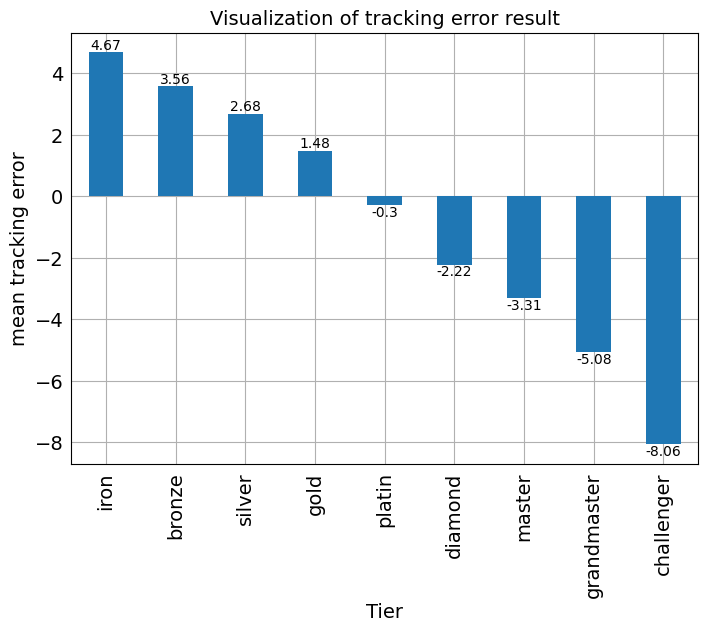

In [40]:
plt.style.use('_mpl-gallery')
plt.style.use('seaborn-v0_8-paper')
plt.figure(figsize=(10,10))
list_tracking_error = [tracking_error_iron.mean(), tracking_error_bronze.mean(), tracking_error_silver.mean(), tracking_error_gold.mean(), tracking_error_platin.mean(),
                      tracking_error_diamond.mean(), tracking_error_master.mean(), tracking_error_grandmaster.mean(), tracking_error_challenger.mean()]

ranks = ["iron", "bronze", "silver", "gold", "platin","diamond", "master", "grandmaster", "challenger"]
d = {"Tracking Error": list_tracking_error, "ranks": ranks}
df_plot = pd.DataFrame(data=d)
ax = df_plot.plot(kind='bar', title='LR Skill Prediction Result Plot ', legend=False)

#splot=sns.barplot(x=["iron", "bronze", "silver", "gold", "platin","diamond", "master", "grandmaster", "challenger"],data=list_tracking_error)
#ax = plt.bar(["iron", "bronze", "silver", "gold", "platin","diamond", "master", "grandmaster", "challenger"], list_tracking_error)
plt.title("Visualization of tracking error result", fontsize=14)
plt.xlabel("Tier", fontsize=14)
plt.ylabel("mean tracking error", fontsize=14)
plt.xticks(np.arange(9), ("iron", "bronze", "silver", "gold", "platin","diamond", "master", "grandmaster", "challenger"), fontsize=14, rotation=90)
plt.yticks(fontsize=14)
ax.bar_label(ax.containers[0])
 
for text in ax.texts:
    t = float(text.get_text())                 
    text.set_text(round(t, 2))

plt.plot()

In [43]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
